# **Introduction**

Here, we're going to fit the ED time series to the RBM representation using infidelity optimization. Since we've explained in more detail how the basic calculations are set up and performed in the [dynamics](dynamics.ipynb) notebook, those details will be skipped here.

Again, we start by including everything.

---

In [2]:
# import everything you need
from src import *
import numpy as np
import matplotlib.pyplot as plt

# set plot properties
# NOTE: to use this setting, you'll need to have TeX installed (remove or comment if you don't have it)
plt.rcParams.update({'font.size': 25,
                     'font.family': 'Candara',
                     'text.usetex': True
                     })

# notebook code reloading
# NOTE: if this casts an error, remove or comment it
%load_ext autoreload
%autoreload 2

# **Settings**

In [3]:
# for the lattice
Lx, Ly = 2,2 # dimensions
lat = hilbert.lattice(Lx, Ly) # the lattice class

# for the network
alpha = 1/4

# for ground state optimization
eta = 0.01

# for dynamics
steps = 2000
endtime = 2
quench = lambda t: 0.5 # a nice quench value

# links to process
# in the flattened labeling of a 2x2 lattice, the (0,2) link is along a quenched bond
links = [(0,2)]

# <span style='color: lightblue'> **Exact diagonalization and ground state** </span>

We need to obtain the ED time series, as we will fit RBM wave functions $\left|\Psi_{RBM}\right>$ to exact wave functions $\left|\Psi_{ED}\right>$. The ground state is there just for the initial state, and is in principle not needed, but it gives a nice way to obtain continuous lines that more resemble the NQS results.

We'll skip the plotting in this part.

## ED

In [4]:
# declare the ED calculation
ed = exact.ED(lat, steps, endtime, perturbator=quench)

# run it
ed.run()

## Ground state

In [ ]:
# declare
gs = groundstate.descent(lat, alpha, eta)

# run
gs.optimize(miniter=1000)

iteration 100 ... energy:  -1.9999963961091347
iteration 200 ... energy:  -1.9999998786310729
iteration 300 ... energy:  -1.999999988137071
iteration 400 ... energy:  -1.999999999914089
iteration 500 ... energy:  -1.9999999999999871
iteration 600 ... energy:  -2.0
iteration 700 ... energy:  -2.0000000000000004
iteration 800 ... energy:  -2.0
iteration 900 ... energy:  -2.0000000000000004
iteration 1000 ... energy:  -2.0


# <span style='color: pink'> **Infidelity optimization** </span>

To fit the RBM ansatz to the exact wave function at each time, we're again using the `dynamics.evolution` class. We have to declare the class object with the system and network properties:
- lattice `lat`,
- network width `alpha`,
- initial state: we'll use the last obtained state from the ground state object `gs`,
- final time `endtime`,
- integration `steps`.

The last two should be the same as in the `exact.ED` object we're using for the optimization.

We will only declare the `evolution` object without runing it (this would initiate the dynamics calculation). Instead, we'll use the `fit_dynamics` method, which requires:
- `states`: a list of states to optimize to; we'll send the list of wave function from ED `ed.states`,
- `links` keyword argument: list of links to calculate correlation functions after the optimization.

The `fit_dynamics` method returns final optimized infidelities and convergence steps, for each state of the `states` list, so we'll write that into some variables. Otherwise, all the other properties (like observables) are accessed through the `evolution` class.

This optimization might take $10-20$ minutes. The algorithm is working hard, performing a gradient descent for every step of the dynamics. Good time to have a coffee.

In [6]:
# declare the class
dyn_fit = dynamics.evolution(lat, alpha, gs.states[-1].copy(), steps, endtime)

# fit to ED
losses, conv_steps = dyn_fit.fit_dynamics(ed.states, links = links,
                    start_from_last = True # this option gives us nice, continuous lines in the eigenvalues
                    )

iteration  100 ... infidelity =  -2.220446049250313e-16
initial fit done in  102 steps, infidelity =  -2.220446049250313e-16
fitting to inputs...


100%|██████████| 2000/2000 [21:26<00:00,  1.55it/s]


calculating correlations at links: [(0, 2)]


100%|██████████| 2001/2001 [00:02<00:00, 877.59it/s] 


calculating spectrum dynamics of the S-matrix


100%|██████████| 2001/2001 [00:04<00:00, 493.15it/s]


## Optimization quaility

We can see how well the optimization went at each time step. This information is written in the `losses` array.

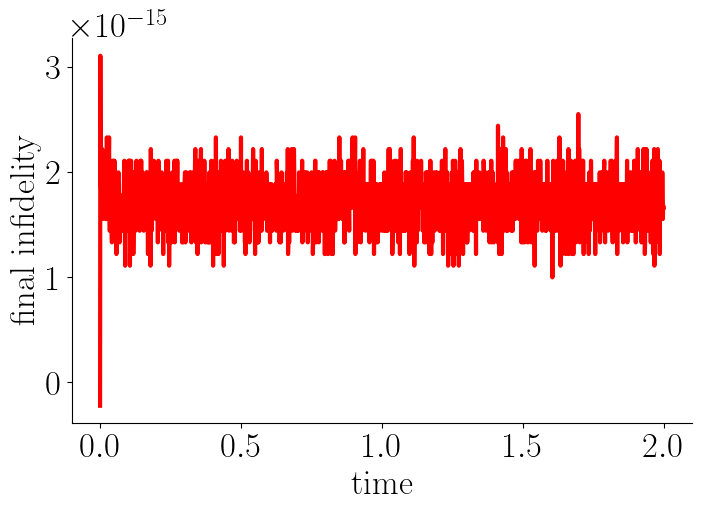

In [40]:
# some plot settings
plt.figure(figsize=(8,5))

# plot NQS run
plt.plot(dyn_fit.times, losses, 
         lw = 3, color = 'red', # line options
         )

# labels
plt.xlabel("time")
plt.ylabel("final infidelity")

# aesthetics
plt.gca().spines[['top', 'right']].set_visible(False)

According to this data, the optimization has converged very nicely at each time.

## Correlation

Let's make sure that the correlation dynamics is the same as ED.

In infidelity fits, the observables are already processed automatically.

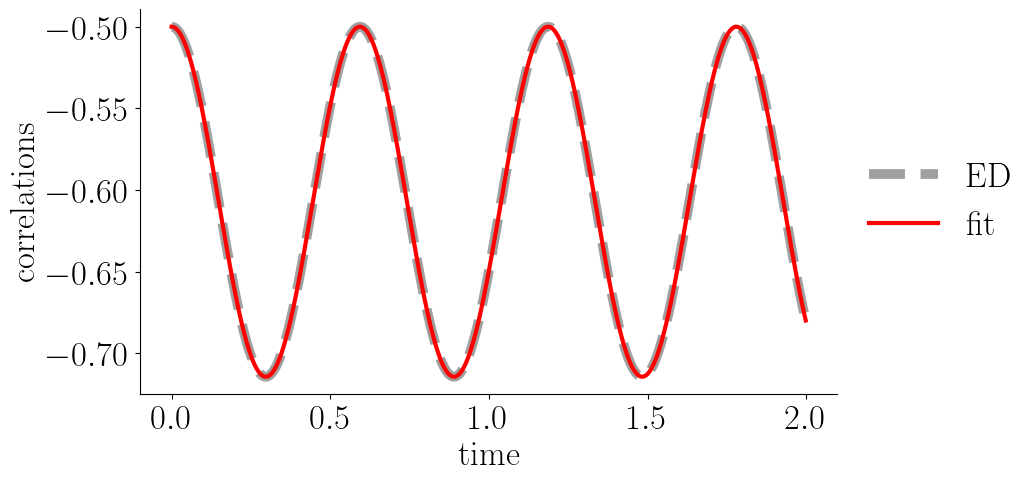

In [41]:
# some plot settings
plt.figure(figsize=(9,5))

# plot benchmark ED
plt.plot(ed.times, ed.observables['correlations'][(0,2)], 
         lw = 7, color = 'gray', alpha = 0.75, ls = '--', # line settings
         label = 'ED')

# plot NQS run
plt.plot(dyn_fit.times, dyn_fit.correlations[(0,2)], 
         lw = 3, color = 'red',
         label = 'fit')

# labels
plt.xlabel("time")
plt.ylabel("correlations")

# aesthetics
plt.legend(frameon = False,  bbox_to_anchor=(1, 0.5), loc='center left')
plt.gca().spines[['top', 'right']].set_visible(False)

Correct correlation dynamics are recovered at each time.

## Spectrum

We can now also see how the eigenvalues of the $S$-matrix look for the infidlity-optimized time seris. These could be considered a good benchmark for actual NQS runs. So, before comparing, let's do a quick NQS run.

In [ ]:
# declare the dynamics class
dyn = dynamics.evolution(lat, alpha, # system settings
                         gs.states[-1].copy(), steps, endtime, # dynamics settings
                         perturbator = quench, # driving (use the same one as with ED)
                         formulation='regularization', regulator = 1e-5)

# run it
dyn.run()

# process it
dyn.process_spectrum()

running simmulation...


100%|██████████| 2000/2000 [00:16<00:00, 123.57it/s]


calculating spectrum dynamics of the S-matrix


100%|██████████| 2001/2001 [00:03<00:00, 545.76it/s]


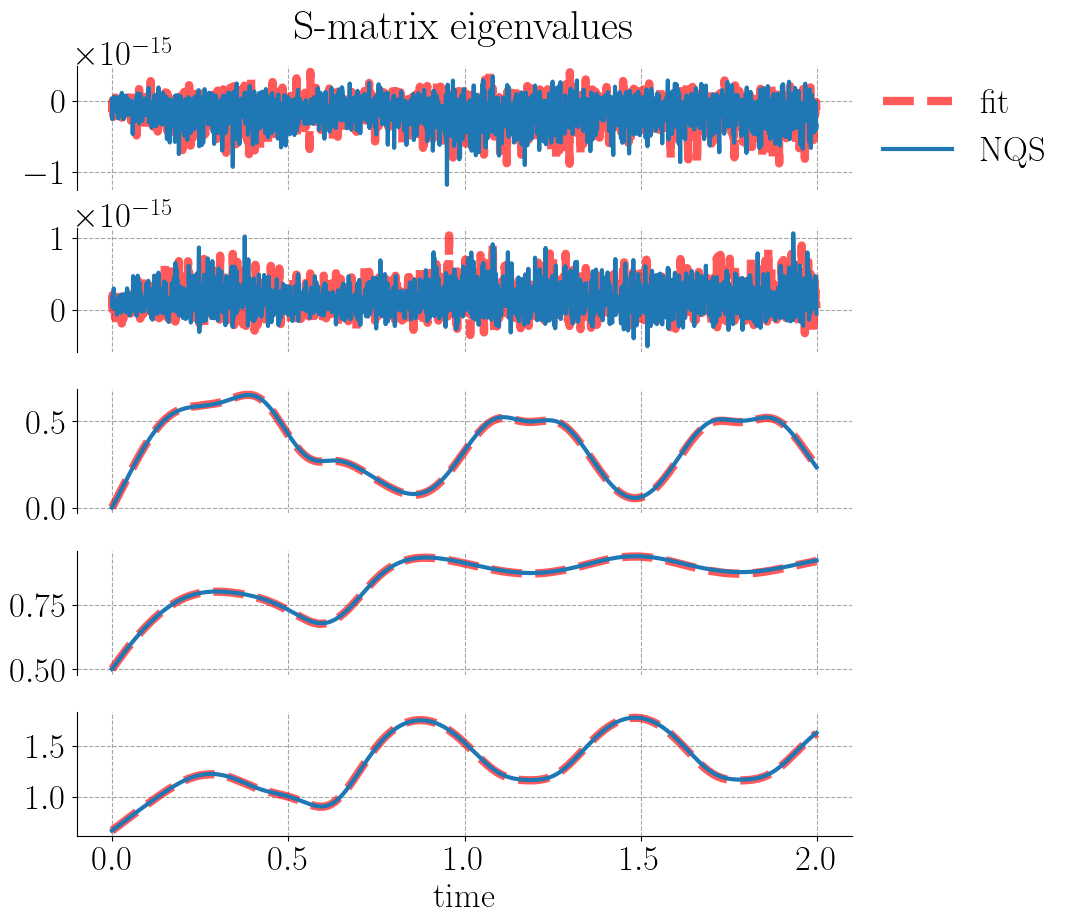

In [49]:
# plot it

# plot settings
fig, axes = plt.subplots(5, 1, figsize = (10, 10), sharex = True)
plt.subplots_adjust(hspace=0.3)

# plot it
for i in range(len(dyn_fit.spectrum)):
    axes[i].plot(dyn_fit.times, dyn_fit.spectrum[i], label = 'fit',
                 color = 'red', alpha = 0.65, lw = 6, ls = '--') # line options
    axes[i].plot(dyn.times, dyn.spectrum[i], label = 'NQS', lw = 3)

# labels and titles
axes[0].set_title("S-matrix eigenvalues", pad = 20)
axes[-1].set_xlabel("time")

# legend
axes[0].legend(frameon = False,  bbox_to_anchor=(1, 0.5), loc='center left')

# aesthetics: graph spines
for i in range(len(axes)-1):
    axes[i].spines[['bottom', 'right', 'top']].set_visible(False)
    axes[i].tick_params(axis='x', length=0)
axes[-1].spines[['right', 'top']].set_visible(False)

# aesthetics: grids
for ax in axes:
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)

The eigenvalues are an excellent match, indicating that the fit is a good variational benchmark for the NQS dynamics with TDVP.